# BLU09 - Information Extraction

In [1]:
# importing needed packages here

import os
import re
import spacy
import hashlib
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter
from spacy.matcher import Matcher
from sklearn.metrics import accuracy_score
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer


def _hash(s):
    return hashlib.sha256(
        bytes(str(s), encoding='utf8'),
    ).hexdigest()

cpu_count = int(os.cpu_count()) if os.cpu_count() != None else 4

In this learning unit you are going to tackle with a quite real problem: **Detecting fake news!** Let's create a binary classifier to determine if a piece of news is considered 'reliable' or 'unreliable'. You will start by building some basic features, then go on to build more complex ones, and finally putting it all together. You should be able to have a working classifier by the end of the notebook.

## Dataset

The dataset we will be using is the [Fake News](https://www.kaggle.com/c/fake-news/overview) from Kaggle. Each piece of news is either reliable or trustworthy, '0', or unreliable and possibly fake, '1'. First, let's load it up and see what we are dealing with.

In [2]:
data_path = "datasets/fakenews/train.csv"
df = pd.read_csv(data_path, index_col=0)
df["title"] = df["title"].astype(str)
df["text"] = df["text"].astype(str)

df = df[:5000]

df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


We can see that we have 4 columns that are pretty self-explanatory, let's drop the author column since we only want to practice our text analysis, drop title as well for simplicity sake.

In [3]:
df.drop(columns=["author", "title"], inplace=True)
df.head()

,text,label
id,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# Let's also load Spacy's model with merged entities (which will come in handy later) and stopwords
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("merge_entities", after="ner")
en_stopwords = nlp.Defaults.stop_words

# Let's get the text of the news article processed by SpaCy - This might take a while depending on 
#   your hardware (a break to walk the dog? 🐶)
docs = list(tqdm(nlp.pipe(df["text"], batch_size=20, n_process=cpu_count-1), total=len(df["text"])))
docs[:3]

100%|██████████| 5000/5000 [12:56<00:00,  6.44it/s]  


[House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
 With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
 As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

Overall, the text looks good! Not too many errors, well written... as expected from a news article. Fake news is a very tough, recent problem that is now appearing more and more frequently in the wild, usually there aren't many ortographic mistakes or slang (as it may happen with spam - another text classification problem!) since it's coming from news sources that want to be/appear credible but also clickbaity so they can profit on that good ad revenue and create distrust.

Nevertheless, it is always good to process any textual information in order to normalize it, remove stopwords and punctuation so we can extract the most important parts of the text.


## Q1. Text Cleaning

#### Q1.a)

With our new previously acquired knowledge, let's remove any stopwords and punctuation from our text column.

In [5]:
tokenizer = WordPunctTokenizer()

def remove_punctuation(text):
    """
    Hint: Remember the good old RegEx from 2 LUs ago
        how can I just remove everything except words, digits and spaces?
    """
    
    text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)

    return text.lower()

def remove_stopwords(text, stopwords):
    """
    Hint: You may want to split the text into tokens using the tokenizer, it might help when searching for stopwords
        If you do, do not forget to join the tokens afterwards!
    """
    token_text = tokenizer.tokenize(text)
    text_no_sw = [word for word in token_text if word not in en_stopwords]
    text_processed = ' '.join(text_no_sw)
    # Return the full string again here
    return text_processed

In [6]:
def preprocess_text(df):
    
    df_processed = df.copy()
    
    df_processed["text"] = df_processed["text"].apply(remove_punctuation)
    assert _hash(df_processed["text"].values) == "9c34086ca91f5845a1069878dd4fd7fcf54826bdf02a0240f644b78257b73137", \
        "it appears you are not removing all of the punctuation, read the hint 😉."
    
    
    df_processed["text"] = df_processed["text"].apply(remove_stopwords, stopwords = en_stopwords)
    assert _hash(df_processed["text"].values) == "e10c9b012ef768908431c03fdc7bf0ae6b11cd2004397f93a9bd262b5d432b8f", \
        "something wrong with removing stopwords, read the hints!"
    
    return df_processed

df_processed = preprocess_text(df)
assert df_processed.shape == (5000, 2), "something is wrong with the shape of the dataframe"

#### Q1.b)

With our text processed, let's get a baseline model for our classification problem! Let's use our comfortable _TfidfVectorizer_ to get a simple, fast and trustworthy baseline.

In [9]:
def baseline_with_tfidf(X_train, X_test, y_train, y_test):
    """
    Train a Random Forest using sklearn's Pipeline and return the trained model and its accuracy in the test set.
    """
    
    pipe = Pipeline([('vect', TfidfVectorizer()), ('clf', RandomForestClassifier())])
    pipe.fit(X_train, y_train)
    
    predicted = pipe.predict(X_test)

    acc = np.mean(predicted == y_test)
    
    
    return pipe, acc

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_processed["text"], df_processed["label"], 
                                                    test_size=0.2, random_state=42, stratify=df_processed["label"])
baseline_model, baseline_acc = baseline_with_tfidf(X_train, X_test, y_train, y_test)

# asserts
assert isinstance(baseline_model, Pipeline)
assert _hash(baseline_model[0]) == "5d9dc3620e12f84e4f957a7b00db14e15ebcc5d20cbc1f883940318fbb5442d5", "Something\
is wrong! Use the default parameters!"
assert _hash(baseline_model[1]) == "7ab1fd7f03f247b36ba389a0a2eb8767ed2f1d2535f8e295669ac5ae2319d3c8", "Something\
is wrong! Use the default parameters!"
assert np.allclose(baseline_acc, 0.908, 0.01), "something wrong with the accuracy score. Use the default parameters."

In [11]:
print('The accuracy of the baseline model is {}'.format(baseline_acc))

The accuracy of the baseline model is 0.912


Wow, the accuracy is quite good for such a simple text model! This just proves that, a starting trustworthy baseline is all you need. I can't stress enough that it's really important to have a simple first iteration, and afterwards we can add complexity and study which features do make sense or not, testing more out of the box solutions. 

Sometimes, data scientists focus right off the bat on the most complex solutions and a simple one would be enough. Real life problems will obviously achieve lower scores as the datasets are not controlled or cleaned for you but that should not stop you from starting with a simpler and easier solution.

Now let's see if adding new features we can still improve our model!

## Q2. SpaCy Matcher

Let's see if we can extract some useful features by using our SpaCy Matcher.

#### Q2.a) Simple Matcher

You think of some words that could be related with the detection of Fake News. Something starts ringing in your mind about "propaganda", "USA" and "fraud", so you decide to check how many of those words appear in our news articles using the SpaCy Matcher

In [12]:
words = ["propaganda", "USA", "fraud"]

# init the matcher - remember it from the learning notebook
# add the patterns of the words. HINT: for a direct match you need a specific pattern (check SpaCy docs)
# count how many matches!

# YOUR CODE HERE
matcher = Matcher(nlp.vocab)

matches_list = []
for word in words:
    pattern = [[{'TEXT': word}]]
    matcher.add(word, pattern)

for doc in docs:
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # the matched span
        matches_list.append(span)

count = len(matches_list)

In [13]:

assert _hash(count) == "d6723fa996ced47773f2dea29cce9b11f951e6dafe321a84ac7d32791c3b4660"

#### Q2.b) POS-Tagging Search

Your head is still working new theories. You start thinking that, fake news might exaggerate on adjectives and adverbs by sharing exaggerated or over the top descriptions. So you decide to create a feature that counts the number of _Adjectives_ and _Adverbs_ in a piece of news article.

In [14]:
# HINT: you already have your news text processed (the docs variable),
# so you can go over every doc and check if there is any POS Tag which is an ADJ or ADV
# to check the POS tag of a token in a doc -----> token.pos_

'''
#Try it out by running the below code! 
for token in docs[0]:
    print(token.pos_)
'''
# Return a list with the number of adjectives and adverbs for every piece of news in docs
nb_adj_adv = []
for doc in docs:
    count = 0
    for token in doc:
        if token.pos_ == 'ADJ' or token.pos_ == 'ADV':
            count += 1
    nb_adj_adv.append(count)   

nb_adj_adv[:10]

[94, 83, 175, 47, 7, 15, 51, 109, 157, 160]

In [15]:
assert type(nb_adj_adv) == list, "the variable should be a list with just 1 dimension."
assert len(nb_adj_adv) == 5000, "the length of the array is wrong. You should have a count for every news article."

value_hash = "f336b90d321d37222abd69b7d15bc12d9190ca7e65014c16966a1ccc2473bdc1"
assert _hash(nb_adj_adv) == value_hash
df_processed["nb_adj_adv"] = nb_adj_adv

#### Q2.c) Entity Search

Another theory that might be worth testing is that people and organizations are often involved in this kind of news. Nowadays, a lot of fake news are often shared by these to justify or divert attention to/from their actions. You think that, another smart feature could be to analyse if there are any known identities (people and/or organizations) that might be closely related with fake news.

In order to do this, you decide to create a Matcher that searches for _People_ and identifies which are the ones that appear most frequently in our piece of news. **Let's find the top 10!**

In [16]:
# I'll reset the matcher for you
matcher = Matcher(nlp.vocab)
#pattern = [[{'POS':'PROPN'}, {"ENT_TYPE": "PERSON"}]] 
pattern = [[{"ENT_TYPE": "PERSON"}]]
matcher.add('LOC', pattern)

# do matches and save the text in a list
names_list = []
for doc in docs:
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        span_text = span.text
        names_list.append(span_text)
# count the number of times the same Person appears on the list (hint: remember the dictionary solution...)
names_dict = {}
for name in names_list:
    if name not in names_dict.keys():
        names_dict[name] = 1
    else:
        names_dict[name] += 1

# only take the top 10 of the counter! THE RESULT SHOULD BE A LIST


In [17]:
names_dict_sorted = (sorted(names_dict.items(), key=lambda item: item[1], reverse=True))
most_common_ents = names_dict_sorted[:10]
most_common_ents

[('Trump', 5161),
 ('Clinton', 3301),
 ('Obama', 1834),
 ('Hillary Clinton', 1752),
 ('Donald Trump', 1674),
 ('Hillary', 1462),
 ('Putin', 542),
 ('Donald J. Trump', 373),
 ('Comey', 366),
 ('Barack Obama', 306)]

In [18]:
assert type(most_common_ents) == list, "the output is not a list"
assert len(most_common_ents) == 10, "It should be the highest 10 people!"

value_hash = "617f391b1470a82dd89f85650d7825c6237ac54cea4e56ef1feb041b3f2b7bb4"
assert _hash(most_common_ents) == value_hash

Well, now I'm curious to see who is on the top 10. Since this dataset is from the USA, I think we can already deduce who is going to show up in the list

In [19]:
most_common_ents

[('Trump', 5161),
 ('Clinton', 3301),
 ('Obama', 1834),
 ('Hillary Clinton', 1752),
 ('Donald Trump', 1674),
 ('Hillary', 1462),
 ('Putin', 542),
 ('Donald J. Trump', 373),
 ('Comey', 366),
 ('Barack Obama', 306)]

As expected, we have some known names here. The matcher was also able to detect full names and join then in a single occurrence (when they appeared together in the sentence). This was only possible since we called the following line

`nlp.add_pipe("merge_entities", after="ner")`

before processing the documents with SpaCy. If we didn't, every name would be considered independent even when belonging to the same person.

We can also check how many times do these people appear for each label of news!

In [20]:
for person, _ in most_common_ents:
    print(person)
    print(df[df['text'].str.contains("")].label.value_counts())
    print()

Trump
1    2532
0    2468
Name: label, dtype: int64

Clinton
1    2532
0    2468
Name: label, dtype: int64

Obama
1    2532
0    2468
Name: label, dtype: int64

Hillary Clinton
1    2532
0    2468
Name: label, dtype: int64

Donald Trump
1    2532
0    2468
Name: label, dtype: int64

Hillary
1    2532
0    2468
Name: label, dtype: int64

Putin
1    2532
0    2468
Name: label, dtype: int64

Donald J. Trump
1    2532
0    2468
Name: label, dtype: int64

Comey
1    2532
0    2468
Name: label, dtype: int64

Barack Obama
1    2532
0    2468
Name: label, dtype: int64



From the distribution it might not be a useful feature at all :(

## Q3. Feature Unions

Now the only thing missing is to create a Feature Union that allows us to join the features we have so far and see if we can actually improve our baseline model

In [21]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]
    
    

#### Q3.a) Adding Extra Features

First off, there are some simple features that we can extract from the dataset to try and to enrich our model! Let's add to our dataframe the following features: **number of words in the doc**, **length of the doc** and **average word length**. Remember we already have the **number of adjectives and adverbs** that we also want to use.

In [89]:
df_processed["doc_length"] = df_processed['text'].map(len)

word_len = lambda row: len(WordPunctTokenizer().tokenize(row)) #number of tokens(words)
df_processed["nb_words"] = df_processed['text'].map(word_len)

avg_word = lambda row: (len("".join(WordPunctTokenizer().tokenize(row)))) #number of total letters without spaces 
df_processed["avg_word_length"] = (df_processed["text"].map(avg_word))/df_processed["nb_words"]
df_processed["avg_word_length"] = df_processed["avg_word_length"].fillna(0) #fill nan with 0
df_processed

,text,label,nb_adj_adv,doc_length,nb_words,avg_word_length
id,,,,,,
0,house dem aide didnt comeys letter jason chaff...,1,94,3155,413,6.641646
1,feeling life circles roundabout heads straight...,0,83,2588,345,6.504348
2,truth fired october 29 2016 tension intelligen...,1,175,4854,620,6.830645
3,videos 15 civilians killed single airstrike id...,1,47,2060,274,6.521898
4,print iranian woman sentenced years prison ira...,1,7,639,83,6.710843
...,...,...,...,...,...,...
4995,washington little affection trust hillary clin...,0,75,2929,398,6.361809
4996,httpmediaarchivesgsradionetdduke112216mp3 dr d...,1,12,592,75,6.906667
4997,los angeles hollywoods secretive unusual jobs ...,0,122,5025,722,5.961219


(0.0, 10000.0)

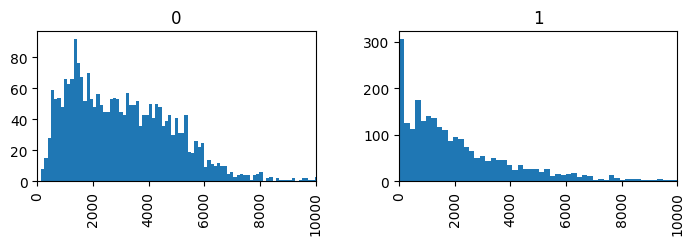

In [87]:
ax_list = df_processed.hist(column='doc_length', by='label', bins=300, figsize=(8,2))
ax_list[0].set_xlim((0,10000))
ax_list[1].set_xlim((0,10000))

In [91]:
assert df_processed.shape == (5000, 6), "Something wrong about the shape, do you have all columns/rows?"
assert "nb_words" in df_processed, "Missing column! Maybe wrong name?"
assert "doc_length" in df_processed, "Missing column! Maybe wrong name?"
assert "avg_word_length" in df_processed, "Missing column! Maybe wrong name?"

hash_nb_words = "bbd0f5a5179c2e0433c3cfd2bf5809c4db8f3b7dfdf44a6729c79c9337ff2361"
hash_doc_length = "3fa5e413714a16c6c9b463ff9883f366dd8fd8e4e46812bdb589365b4afbe54d"
hash_avg_word_length = "9c11f12992d183e81f7c20ebc3e901fc4b2ef56ab01d2d2046f0603f70abb043"

assert _hash(df_processed["nb_words"]) == hash_nb_words, "Something wrong with how you are calculating this column."
assert _hash(df_processed["doc_length"]) == hash_doc_length, "Something wrong with how you are calculating this column."
assert _hash(df_processed["avg_word_length"]) == hash_avg_word_length, "Something wrong with how you are calculating this column."


##### Q3 b) Feature Union

Let's create a processing _Pipeline_ for every new feature and then join them all using a _Feature Union_. For the textual feature use the usual _TfidfVectorizer_ with default parameters and for any numerical feature use a _Standard Scaler_. Afterwards, join the features pipelines using a _Feature Union_.

In [74]:
text_pipe = Pipeline([('selector', TextSelector("text")),
('tfidf', TfidfVectorizer())])

nb_adj_adv_pipe = Pipeline([('selector', NumberSelector("nb_adj_adv")),
('standard', StandardScaler())])

nb_words_pipe = Pipeline([('selector', NumberSelector("nb_words")),
('standard', StandardScaler())])

doc_length_pipe = Pipeline([('selector', NumberSelector("doc_length")),
('standard', StandardScaler())])

avg_word_length_pipe = Pipeline([('selector', NumberSelector("avg_word_length")),
('standard', StandardScaler())])


feats = FeatureUnion([('text', text_pipe), ('nb_adj_adv', nb_adj_adv_pipe),
('nb_words', nb_words_pipe), ('doc_length',doc_length_pipe),
('avg_word_length', avg_word_length_pipe)])


In [75]:
assert isinstance(feats, FeatureUnion)
assert len(feats.transformer_list) == 5, "Are you creating 5 pipelines? One for each feature?"
for pipe in feats.transformer_list:
    
    selector = pipe[1][0]
    if not (isinstance(selector, TextSelector) or isinstance(selector, NumberSelector)):
        raise AssertionError("pipeline is wrong, the Selectors should come first.")
        
    feature_builder = pipe[1][1]
    if not (isinstance(feature_builder, TfidfVectorizer) or isinstance(feature_builder, StandardScaler)):
        raise AssertionError("pipeline is wrong, the second thing to come should be the Tfidf or the Scaler.")
    

Now let's build our function to use our newly created _Feature Union_ and calculate its performance!

In [93]:
def improved_pipeline(feats, X_train, X_test, y_train, y_test):
    """
    Train a Random Forest using sklearn's Pipeline and return the trained model and its accuracy in the test set.
    Don't forget to add the feats to the Pipeline!
    """
    
    pipe = Pipeline([('feats', feats), ('clf', RandomForestClassifier())])
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    acc = np.mean(preds == y_test)
    
    return pipe, acc

In [92]:
Y = df_processed["label"]
X = df_processed.drop(columns="label")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
pipeline_model, pipeline_acc = improved_pipeline(feats, X_train, X_test, y_train, y_test)

# asserts
assert isinstance(pipeline_model, Pipeline)
assert _hash(pipeline_model[0]) == "f5e738d891cee945082226770873c560481fccce687af07ea966b30de065ac35", "The first part of the\
Pipeline is incorrect."
assert _hash(pipeline_model[1]) == "7ab1fd7f03f247b36ba389a0a2eb8767ed2f1d2535f8e295669ac5ae2319d3c8", "The second part of the\
Pipeline is incorrect."
assert np.allclose(pipeline_acc, 0.896, 0.03), "something wrong with the accuracy score. Use the default parameters."

With this more complex approach we have achieved a very similar performance when compared to our baseline. This might mean a lot of things: our features might have no real revelance to the model (which you will learn how to check later on with some feature importance) or we have achieved a plateau and can't improve the score with the this technique. 

Nevertheless it is a good score for this problem and dataset. Regardless you have learnt a lot about _POS Tagging_, _Entities_, _Feature Union_ and also leant that the sky is the limit when creating features. anything can be a feature really - now good features are a totally different thing that might need more research and validation.